In [75]:
# Загружаем необходимые библиотеки
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [20]:
# Установка библиотеки py7zr
!pip install py7zr

# Импортирование библиотеки
import py7zr
import os

# Путь к архиву
archive_path = "./datasets.7z"

# Директория для распаковки
extract_dir = "./datasets"

# Распаковка архива
with py7zr.SevenZipFile(archive_path, mode='r') as z:
    z.extractall(path=extract_dir)

In [24]:
# Директории с данными для обучения и тестирования
train_dir = "./datasets/Classification datasets/train"
test_dir = "./datasets/Classification datasets/test"

In [68]:
# Функция для вывода структуры директорий
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("./datasets/")

There are 1 directories and 0 images in './datasets/'.
There are 2 directories and 0 images in './datasets/Classification datasets'.
There are 2 directories and 0 images in './datasets/Classification datasets/test'.
There are 0 directories and 57 images in './datasets/Classification datasets/test/norust'.
There are 0 directories and 57 images in './datasets/Classification datasets/test/rust'.
There are 2 directories and 0 images in './datasets/Classification datasets/train'.
There are 0 directories and 228 images in './datasets/Classification datasets/train/norust'.
There are 0 directories and 228 images in './datasets/Classification datasets/train/rust'.


In [69]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [25]:
# Размер изображений
IMG_SIZE = (224, 224)

# Загрузка данных для обучения
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="binary",
    image_size=IMG_SIZE,
)

# Загрузка данных для тестирования
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    image_size=IMG_SIZE
)

# Форма входных данных
input_shape = (224, 224, 3)

Found 456 files belonging to 2 classes.
Found 114 files belonging to 2 classes.


In [29]:
# Слой для аугментации данных
data_augmentation = tf.keras.Sequential([
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.Rescaling(scale=1./255)
], name="augmentation_layer")

In [31]:
# Базовая модель VGG16 без верхних слоев, предобученная на ImageNet
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
base_model.trainable = False

# Создание модели
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

# Компиляция модели
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.02),
    metrics=["accuracy"]
)

In [36]:
# Начальная эпоха
initial_epoch = 0

# Количество эпох для обучения
fine_tune_epochs = initial_epoch + 5

# Обучение модели
history = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch=initial_epoch,
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="fine_tune_all_classes")]
)

Saving TensorBoard log files to: transfer_learning/fine_tune_all_classes/20241128-100629
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 267s 18s/step - accuracy: 0.8601 - loss: 0.3535 - val_accuracy: 0.8750 - val_loss: 0.3148
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 346s 20s/step - accuracy: 0.8667 - loss: 0.3034 - val_accuracy: 0.8438 - val_loss: 0.2795
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 291s 18s/step - accuracy: 0.8995 - loss: 0.2512 - val_accuracy: 0.9375 - val_loss: 0.1588
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 263s 18s/step - accuracy: 0.8730 - loss: 0.3021 - val_accuracy: 0.8333 - val_loss: 0.4164
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8951 - loss: 0.2337 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 363s 20s/step - accuracy: 0.8948 - loss: 0.2348


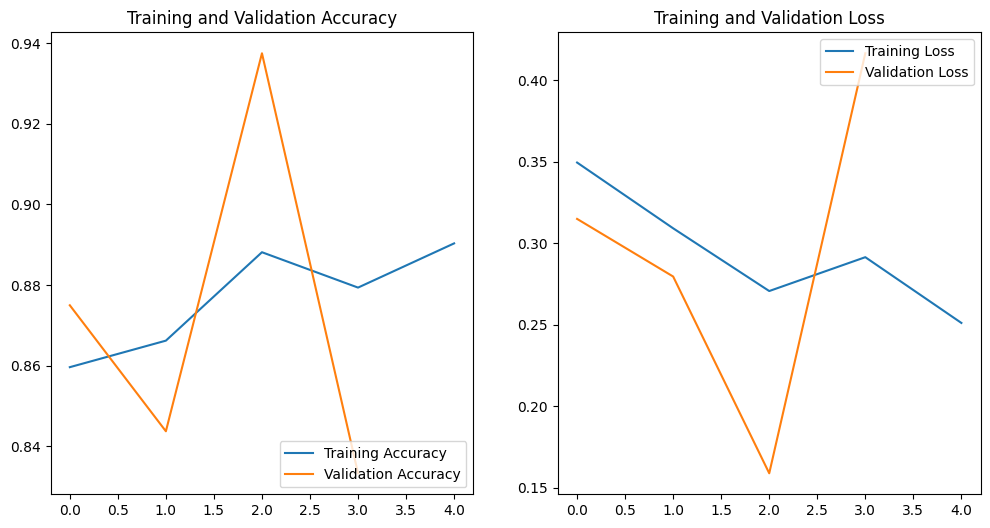

In [51]:
# Визуализация графика потерь и точности
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(5), acc, label='Training Accuracy')
    plt.plot(range(4), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(5), loss, label='Training Loss')
    plt.plot(range(4), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

In [38]:
# Вывод структуры модели
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, None, None, 512)     │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,716 (56.14 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 515 (2.02 KB)

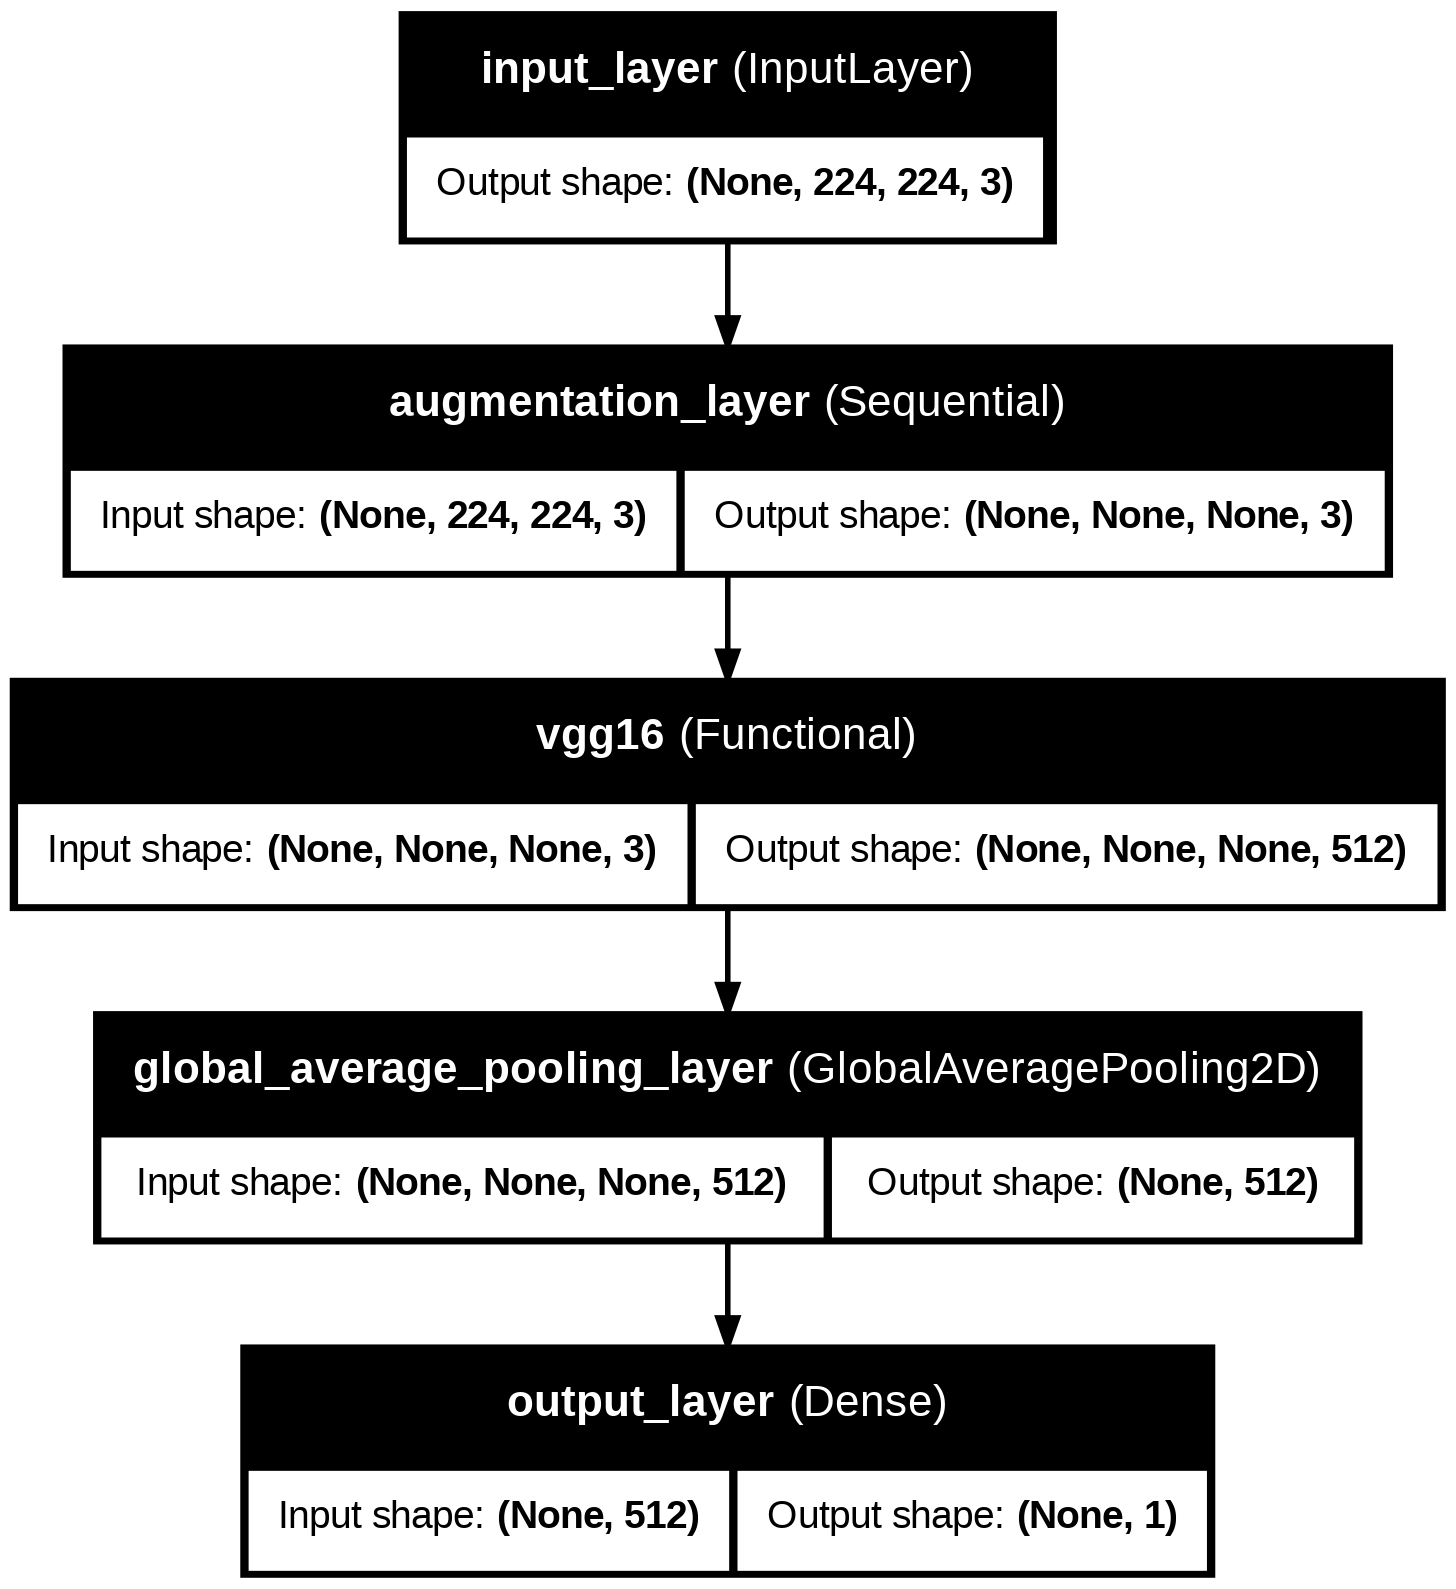

In [39]:
# Визуализация архитектуры модели
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

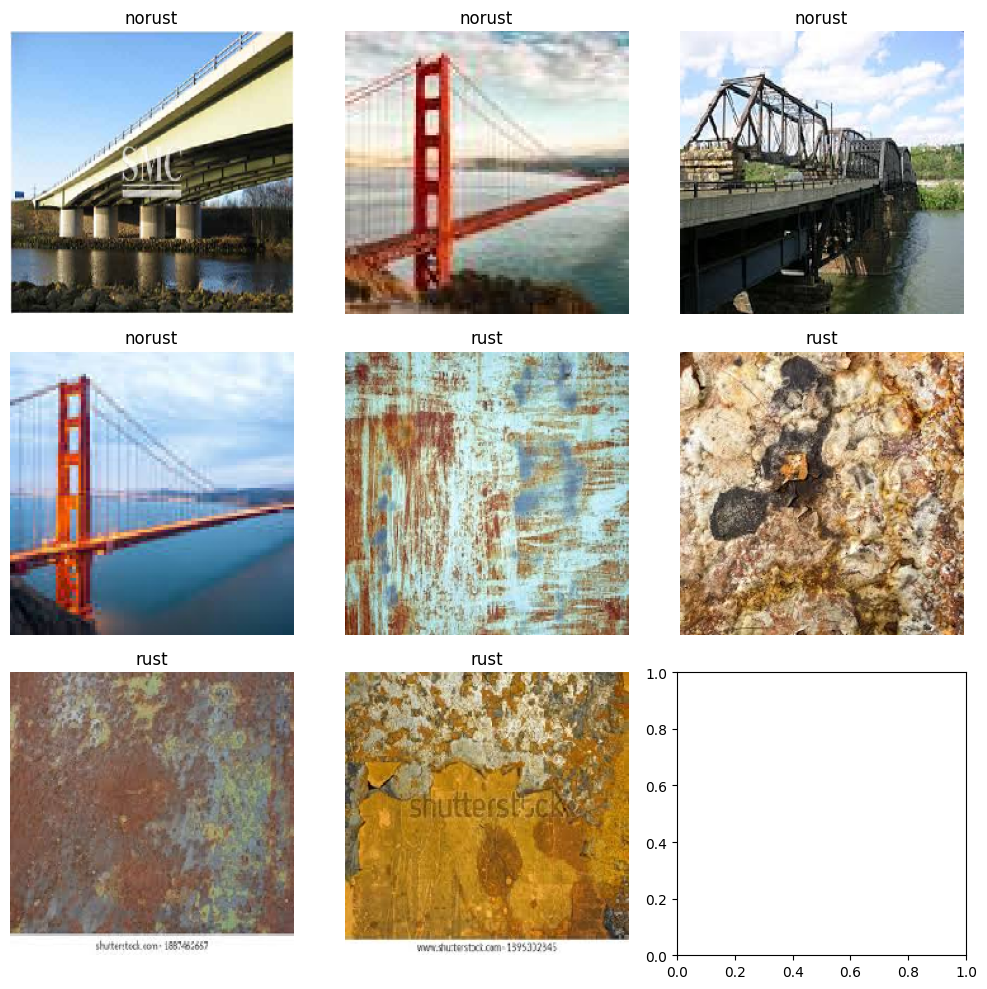

In [55]:
# Визуализация нескольких изображений из тренировочного набора данных
def plot_sample_images(directory, num_images=9, img_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(directory)

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        random.shuffle(image_files)
        for image_file in image_files[:num_images//len(class_names)]:
            img_path = os.path.join(class_dir, image_file)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_name)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.astype('uint8'))
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_dir)

In [56]:
# Оценка модели
results = model.evaluate(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 15s/step - accuracy: 0.8815 - loss: 0.2323


In [59]:
# Сохранение модели
model.save("rust_detector.keras")

In [71]:
def load_and_preprocess_image(image_path, img_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [62]:
# Загрузка сохраненной модели
model = tf.keras.models.load_model("rust_detector.keras")

In [114]:
# Путь к изображению для тестирования
image_path1 = './234.jpg'

In [115]:
# Предобработка изображения
img_array1 = load_and_preprocess_image(image_path1)

In [116]:
# Предсказание
prediction = model.predict(img_array1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


In [117]:
# Интерпретация результата
if prediction[0] > 0.5:
    print("Изображение классифицировано как: Коррозия")
else:
    print("Изображение классифицировано как: Без коррозии")

Изображение классифицировано как: Коррозия


In [118]:
# Путь к изображению для тестирования
image_path2 = './metal5.jpg'

In [119]:
# Предобработка изображения
img_array2 = load_and_preprocess_image(image_path2)

In [120]:
# Предсказание
prediction = model.predict(img_array2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


In [122]:
# Интерпретация результата
if prediction[0] > 0.5:
    print("Изображение классифицировано как: Коррозия")
else:
    print("Изображение классифицировано как: Без коррозии")

Изображение классифицировано как: Коррозия


In [133]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import tensorflow as tf

def load_keras_image(model, img_path, target_size=(224, 224)):
    # Чтение и изменение рамзера
    img = image.load_img(img_path, target_size=target_size)
    plt.imshow(img)
    plt.show()

    test_x = image.img_to_array(img)

    test_x = np.expand_dims(test_x, axis=0)

    test_x = test_x.astype('float32') / 255.0

    rust_prob = model.predict(test_x)
    print(f"Prediction: {rust_prob}")

    if rust_prob > 0.5:
        print("This is a rust image")
    else:
        print("This is a no rust image")

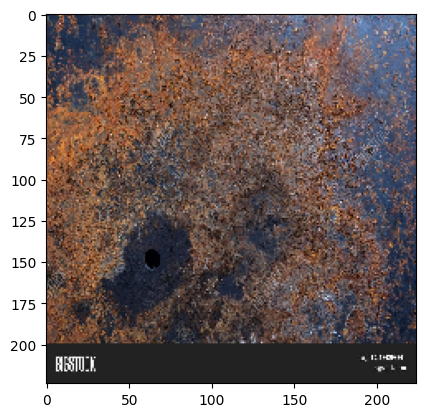

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Prediction: [[0.6114712]]
This is a rust image


In [135]:
# Пример использования
model = tf.keras.models.load_model("rust_detector.keras")
image_path = './234.jpg'
load_keras_image(model, image_path)